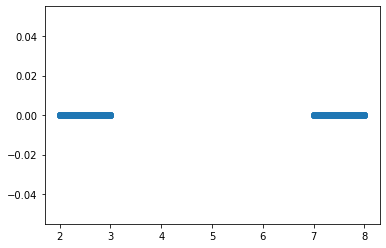

In [1]:
import numpy as np
import matplotlib.pyplot as plt
a1 = np.random.rand(250) + 2
a2 = np.random.rand(250) + 7
b = np.zeros(500)
a = np.concatenate((a1,a2), axis=0)
plt.scatter(a,b)
plt.show()

In [2]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.layers import Dense
from keras import Input, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib import pyplot
from keras import backend as K
from keras.constraints import Constraint
from keras.initializers import RandomNormal
import tensorflow as tf

In [3]:
def wasserstein_loss(y_true, y_pred):
	  return K.mean(y_true * y_pred)
 
class ClipConstraint(Constraint):
    def __init__(self, clip_value):
      self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
      return K.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
  	  return {'clip_value': self.clip_value}

def define_discriminator():
    init = RandomNormal(stddev=0.02)
    const = ClipConstraint(0.05)
    inputs = Input(shape=(1,))
    x = Dense(8, kernel_initializer=init, kernel_constraint=const, activation='relu')(inputs)
    x = Dense(16, kernel_initializer=init, kernel_constraint=const, activation='relu')(x)
    x = Dense(32, kernel_initializer=init, kernel_constraint=const, activation='relu')(x)
    x = Dense(64, kernel_initializer=init, kernel_constraint=const, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs,outputs)
    opt = RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

def define_generator(latent_dim, n_outputs=1):
    inputs = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    outputs = Dense(n_outputs, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

def define_gan(generator, discriminator):
    discriminator.trainable = False
    gen_noise = generator.input
    gen_output = generator.output
    gan_output = discriminator(gen_output)
    model = Model(gen_noise, gan_output)
    opt = RMSprop(learning_rate=0.00008)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model
    
def generate_real_samples(n):
    ix = np.random.randint(0, 500, n)
    X = a[ix]

    y = -ones((n, 1))
    return X, y

def generate_latent_points(latent_dim, n):
    x_input = randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    x_input = tf.convert_to_tensor(x_input, dtype=tf.float32)
    X = generator(x_input)
    y = ones((n, 1))
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    return X, y
    
def summarize_performance(epoch, generator, discriminator, latent_dim, n=50):
    x_real, y_real = generate_real_samples(n)
    acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    ll = np.linspace(0, 10, 50, endpoint=False)
    ll = ll.astype('float32')
    aa = discriminator(ll)

    c = np.zeros(n)
    plt.plot(ll,aa)
    plt.scatter(x_real[0:], c, alpha=0.6)
    plt.scatter(x_fake, c, alpha=0.6)
    plt.show()
    plt.close()

def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.show()

def train(g_model, d_model, gan_model, latent_dim, n_epochs=15000, n_batch=64, n_eval=50):
    half_batch = int(n_batch / 2)

    c1_hist, c2_hist, g_hist = list(), list(), list()
    for i in range(n_epochs):
        c1_tmp, c2_tmp = list(), list()
        for j in range(3):
            x_real, y_real = generate_real_samples(n_batch)
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            c_loss1 = d_model.train_on_batch(x_real, y_real)
            c_loss2 = d_model.train_on_batch(x_fake, y_fake)
            c1_tmp.append(c_loss1)
            c2_tmp.append(c_loss2)

        for j in range(1):
            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = -ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(x_gan, y_gan)

        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        g_hist.append(g_loss)

        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            print(i)
            plot_history(c1_hist, c2_hist, g_hist)

latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim)

Output hidden; open in https://colab.research.google.com to view.